In [486]:
import pandas as pd
import numpy as np

from tqdm import tqdm
from pandarallel import pandarallel

pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [487]:
df = pd.read_csv("../data/preprocessed/colex_pron_geo_glottolog.csv")

In [488]:
df.LANG_PRON.value_counts()

fra    98338
fin    86301
slv    80158
spa    73306
ind    63544
       ...  
lij        1
xal        1
rgn        1
kbd        1
syl        1
Name: LANG_PRON, Length: 159, dtype: int64

In [489]:
conc_dict = dict(zip(df["C1"], df["Conc.M.1"]))
conc_dict_2 = dict(zip(df["C2"], df["Conc.M.2"]))
conc_dict.update(conc_dict_2)

In [490]:
df = df[df["SYNSET1"].str.contains("#1")]

In [491]:
df = df[df["SYNSET2"].str.contains("#1")]

In [492]:
len(df.LANG_PRON.value_counts()), len(df)

(142, 284084)

In [493]:
concepts = set(df_test["C1"].tolist()+df_test["C2"].tolist())

In [494]:
concepts

{'bulge', 'gnarl', 'knot', 'murmur'}

In [495]:
lemmas,langs, prons, concs = [],[],[],[]
for x, group in df.groupby(["SENSE_LEMMA", "LANG_PRON", "PRON"]):
    lemmas.append(x[0])
    langs.append(x[1])
    prons.append(x[2])
    
    concepts = list(set(group["C1"].tolist()+group["C2"].tolist()))
    conclist = [conc_dict[x] for x in concepts]
    concs.append(np.mean(conclist))
    

In [498]:
df.to_csv("../data/colex/colex_pron_wn#1.csv", index=False)

In [397]:
phondf = pd.DataFrame.from_dict({"SENSE_LEMMA": lemmas, "LANG_PRON":langs, "PRON":prons, "Conc":concs})

In [398]:
phondf

,SENSE_LEMMA,LANG_PRON,PRON,Conc
0,a,eng,e ɪ,2.035000
1,a,hun,aː,3.561429
2,a,ita,a,3.150000
3,aaien,nld,aː i̯ ə n,4.393333
4,aal,nld,aː l,4.585000
...,...,...,...,...
77991,𐌿𐍂𐍂𐌿𐌽𐍃,got,u r r u n s,3.765000
77992,𐍃𐌺𐌴𐌹𐌼𐌰,got,s k iː m a,4.880000
77993,𐍅𐌰𐌹𐌽𐌰𐌷𐍃,got,w ɛː n a h s,2.005000
77994,𐍅𐍉𐌸𐌴𐌹𐍃,got,w oː θ iː s,2.775000


In [399]:
import panphon
ft = panphon.FeatureTable()

In [263]:
ft.word_fts(u"k ɑ p i n o i̯ d ɑˣ")

[<Segment [-syl, -son, +cons, -cont, -delrel, -lat, -nas, 0strid, -voi, -sg, -cg, -ant, -cor, 0distr, -lab, +hi, -lo, +back, -round, -velaric, 0tense, -long, 0hitone, 0hireg]>,
 <Segment [+syl, +son, -cons, +cont, 0delrel, -lat, -nas, 0strid, +voi, -sg, -cg, 0ant, -cor, 0distr, -lab, -hi, +lo, +back, -round, -velaric, +tense, -long, 0hitone, 0hireg]>,
 <Segment [-syl, -son, +cons, -cont, -delrel, -lat, -nas, 0strid, -voi, -sg, -cg, +ant, -cor, 0distr, +lab, -hi, -lo, -back, -round, -velaric, 0tense, -long, 0hitone, 0hireg]>,
 <Segment [+syl, +son, -cons, +cont, -delrel, -lat, -nas, 0strid, +voi, -sg, -cg, 0ant, -cor, 0distr, -lab, +hi, -lo, -back, -round, -velaric, +tense, -long, 0hitone, 0hireg]>,
 <Segment [-syl, +son, +cons, -cont, -delrel, -lat, +nas, 0strid, +voi, -sg, -cg, +ant, +cor, -distr, -lab, -hi, -lo, -back, -round, -velaric, 0tense, -long, 0hitone, 0hireg]>,
 <Segment [+syl, +son, -cons, +cont, -delrel, -lat, -nas, 0strid, +voi, -sg, -cg, 0ant, -cor, 0distr, -lab, -hi, -l

In [1]:
features = ["syl", "son", "cons", "cont", "delrel", "lat", "nas", "strid", "voi", "sg", "cg", "ant", 
            "cor", "distr", "lab", "hi", "lo", "back", "round", "velaric", "tense", "long", "hitone", "hireg"]

In [2]:
len(features)

24

In [401]:
Initial_features = [f"init_{x}" for x in features]
all_features = Initial_features+features

In [402]:
def get_phon_features(phone):
    r = ft.word_to_vector_list(phone, numeric=True)
    r_arr = np.array(r)
    seg_len = r_arr.shape[0]
    
    r_initials = r[0]
    r_values = np.count_nonzero(r_arr==1, axis=0)/seg_len
    
    rs = np.concatenate((r_initials, r_values), axis=0)
    return pd.Series(rs)

In [403]:
f  = get_phon_features("w iː x s")

In [405]:
phondf[all_features]= phondf["PRON"].parallel_apply(get_phon_features)

In [421]:
phondf.head(2)

,SENSE_LEMMA,LANG_PRON,PRON,Conc,init_syl,init_son,init_cons,init_cont,init_delrel,init_lat,init_nas,init_strid,init_voi,init_sg,init_cg,init_ant,init_cor,init_distr,init_lab,init_hi,init_lo,init_back,init_round,init_velaric,init_tense,init_long,init_hitone,init_hireg,syl,son,cons,cont,delrel,lat,nas,strid,voi,sg,cg,ant,cor,distr,lab,hi,lo,back,round,velaric,tense,long,hitone,hireg
0,a,eng,e ɪ,2.035000,1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,0.0,1.0,-1.0,-1.0,0.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0
1,a,hun,aː,3.561429,1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,0.0,1.0,-1.0,-1.0,0.0,-1.0,0.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [407]:
import matplotlib.pyplot as plt  # To visualize
import json
from collections import Counter, defaultdict

from sklearn.linear_model import LinearRegression
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_columns', 60)


In [408]:
# phondf.to_csv("../data/phon/wn_panphon.csv", index=False)

In [409]:
phondf

,SENSE_LEMMA,LANG_PRON,PRON,Conc,init_syl,init_son,init_cons,init_cont,init_delrel,init_lat,init_nas,init_strid,init_voi,init_sg,init_cg,init_ant,init_cor,init_distr,init_lab,init_hi,init_lo,init_back,init_round,init_velaric,init_tense,init_long,init_hitone,init_hireg,syl,son,cons,cont,delrel,lat,nas,strid,voi,sg,cg,ant,cor,distr,lab,hi,lo,back,round,velaric,tense,long,hitone,hireg
0,a,eng,e ɪ,2.035000,1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,0.0,1.0,-1.0,-1.0,0.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,0.0,0.0,1.000000,1.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.500000,0.000000,0.000000,0.000000,0.0,0.500000,0.000000,0.0,0.0
1,a,hun,aː,3.561429,1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,0.0,1.0,-1.0,-1.0,0.0,-1.0,0.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,0.0,0.0,1.000000,1.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,1.000000,1.000000,0.0,0.0
2,a,ita,a,3.150000,1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,0.0,1.0,-1.0,-1.0,0.0,-1.0,0.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,0.0,0.0,1.000000,1.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.0,0.0
3,aaien,nld,aː i̯ ə n,4.393333,1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,0.0,1.0,-1.0,-1.0,0.0,-1.0,0.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,0.0,0.0,0.500000,1.000000,0.250000,0.750000,0.0,0.000000,0.250000,0.000000,1.000000,0.0,0.0,0.250000,0.250000,0.0,0.000000,0.250000,0.250000,0.250000,0.000000,0.0,0.500000,0.250000,0.0,0.0
4,aal,nld,aː l,4.585000,1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,0.0,1.0,-1.0,-1.0,0.0,-1.0,0.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,0.0,0.0,0.500000,1.000000,0.500000,1.000000,0.0,0.500000,0.000000,0.000000,1.000000,0.0,0.0,0.500000,0.500000,0.0,0.000000,0.000000,0.500000,0.000000,0.000000,0.0,0.500000,0.500000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77991,𐌿𐍂𐍂𐌿𐌽𐍃,got,u r r u n s,3.765000,1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,0.0,1.0,-1.0,-1.0,0.0,-1.0,0.0,1.0,1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,0.0,0.0,0.333333,0.833333,0.666667,0.833333,0.0,0.000000,0.166667,0.000000,0.833333,0.0,0.0,0.666667,0.666667,0.0,0.333333,0.333333,0.000000,0.333333,0.333333,0.0,0.333333,0.000000,0.0,0.0
77992,𐍃𐌺𐌴𐌹𐌼𐌰,got,s k iː m a,4.880000,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,0.0,0.0,0.400000,0.600000,0.600000,0.600000,0.0,0.000000,0.200000,0.000000,0.600000,0.0,0.0,0.400000,0.200000,0.0,0.200000,0.400000,0.200000,0.200000,0.000000,0.0,0.400000,0.200000,0.0,0.0
77993,𐍅𐌰𐌹𐌽𐌰𐌷𐍃,got,w ɛː n a h s,2.005000,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,0.0,1.0,-1.0,-1.0,-1.0,-1.0,0.0,1.0,1.0,-1.0,1.0,1.0,-1.0,0.0,-1.0,0.0,0.0,0.333333,0.833333,0.500000,0.833333,0.0,0.000000,0.166667,0.000000,0.666667,0.0,0.0,0.333333,0.333333,0.0,0.166667,0.166667,0.166667,0.166667,0.166667,0.0,0.166667,0.166667,0.0,0.0
77994,𐍅𐍉𐌸𐌴𐌹𐍃,got,w oː θ iː s,2.775000,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,0.0,1.0,-1.0,-1.0,-1.0,-1.0,0.0,1.0,1.0,-1.0,1.0,1.0,-1.0,0.0,-1.0,0.0,0.0,0.400000,0.600000,0.400000,1.000000,0.0,0.000000,0.000000,0.000000,0.600000,0.0,0.0,0.400000,0.400000,0.2,0.200000,0.400000,0.000000,0.400000,0.400000,0.0,0.400000,0.400000,0.0,0.0


In [411]:
import scipy.stats

<Axes: xlabel='Conc', ylabel='Count'>

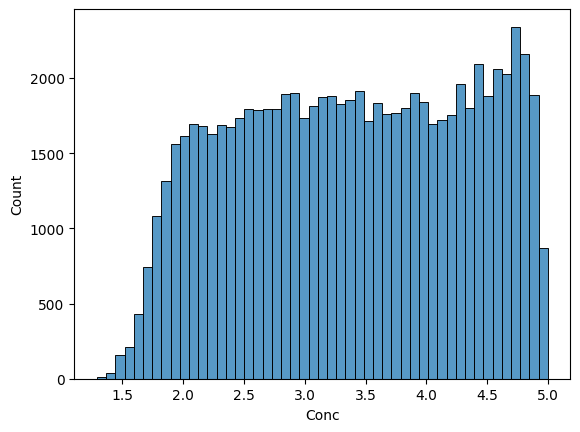

In [420]:
sns.histplot(data=phondf, x="Conc")

In [445]:
df_features = phondf[features]
df_init_features = phondf[Initial_features]

In [483]:
phondf

,SENSE_LEMMA,LANG_PRON,PRON,Conc,init_syl,init_son,init_cons,init_cont,init_delrel,init_lat,init_nas,init_strid,init_voi,init_sg,init_cg,init_ant,init_cor,init_distr,init_lab,init_hi,init_lo,init_back,init_round,init_velaric,init_tense,init_long,init_hitone,init_hireg,syl,son,cons,cont,delrel,lat,nas,strid,voi,sg,cg,ant,cor,distr,lab,hi,lo,back,round,velaric,tense,long,hitone,hireg
0,a,eng,e ɪ,2.035000,1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,0.0,1.0,-1.0,-1.0,0.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,0.0,0.0,1.000000,1.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.500000,0.000000,0.000000,0.000000,0.0,0.500000,0.000000,0.0,0.0
1,a,hun,aː,3.561429,1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,0.0,1.0,-1.0,-1.0,0.0,-1.0,0.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,0.0,0.0,1.000000,1.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,1.000000,1.000000,0.0,0.0
2,a,ita,a,3.150000,1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,0.0,1.0,-1.0,-1.0,0.0,-1.0,0.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,0.0,0.0,1.000000,1.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.0,0.0
3,aaien,nld,aː i̯ ə n,4.393333,1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,0.0,1.0,-1.0,-1.0,0.0,-1.0,0.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,0.0,0.0,0.500000,1.000000,0.250000,0.750000,0.0,0.000000,0.250000,0.000000,1.000000,0.0,0.0,0.250000,0.250000,0.0,0.000000,0.250000,0.250000,0.250000,0.000000,0.0,0.500000,0.250000,0.0,0.0
4,aal,nld,aː l,4.585000,1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,0.0,1.0,-1.0,-1.0,0.0,-1.0,0.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,0.0,0.0,0.500000,1.000000,0.500000,1.000000,0.0,0.500000,0.000000,0.000000,1.000000,0.0,0.0,0.500000,0.500000,0.0,0.000000,0.000000,0.500000,0.000000,0.000000,0.0,0.500000,0.500000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77991,𐌿𐍂𐍂𐌿𐌽𐍃,got,u r r u n s,3.765000,1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,0.0,1.0,-1.0,-1.0,0.0,-1.0,0.0,1.0,1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,0.0,0.0,0.333333,0.833333,0.666667,0.833333,0.0,0.000000,0.166667,0.000000,0.833333,0.0,0.0,0.666667,0.666667,0.0,0.333333,0.333333,0.000000,0.333333,0.333333,0.0,0.333333,0.000000,0.0,0.0
77992,𐍃𐌺𐌴𐌹𐌼𐌰,got,s k iː m a,4.880000,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,0.0,0.0,0.400000,0.600000,0.600000,0.600000,0.0,0.000000,0.200000,0.000000,0.600000,0.0,0.0,0.400000,0.200000,0.0,0.200000,0.400000,0.200000,0.200000,0.000000,0.0,0.400000,0.200000,0.0,0.0
77993,𐍅𐌰𐌹𐌽𐌰𐌷𐍃,got,w ɛː n a h s,2.005000,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,0.0,1.0,-1.0,-1.0,-1.0,-1.0,0.0,1.0,1.0,-1.0,1.0,1.0,-1.0,0.0,-1.0,0.0,0.0,0.333333,0.833333,0.500000,0.833333,0.0,0.000000,0.166667,0.000000,0.666667,0.0,0.0,0.333333,0.333333,0.0,0.166667,0.166667,0.166667,0.166667,0.166667,0.0,0.166667,0.166667,0.0,0.0
77994,𐍅𐍉𐌸𐌴𐌹𐍃,got,w oː θ iː s,2.775000,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,0.0,1.0,-1.0,-1.0,-1.0,-1.0,0.0,1.0,1.0,-1.0,1.0,1.0,-1.0,0.0,-1.0,0.0,0.0,0.400000,0.600000,0.400000,1.000000,0.0,0.000000,0.000000,0.000000,0.600000,0.0,0.0,0.400000,0.400000,0.2,0.200000,0.400000,0.000000,0.400000,0.400000,0.0,0.400000,0.400000,0.0,0.0


In [484]:
df_features.corrwith(phondf["Conc"])

syl       -0.058234
son       -0.037660
cons       0.032510
cont      -0.050868
delrel     0.014171
lat        0.032920
nas       -0.057400
strid     -0.029646
voi       -0.051191
sg         0.045578
cg         0.019453
ant       -0.052659
cor       -0.064376
distr      0.012673
lab        0.039460
hi         0.011528
lo         0.048987
back       0.064203
round      0.036445
velaric    0.004235
tense     -0.024244
long       0.026489
hitone     0.041774
hireg      0.036306
dtype: float64

In [485]:
df_init_features.corrwith(phondf["Conc"])  # syl, son, cons, cont.

init_syl       -0.144740
init_son       -0.101947
init_cons       0.136961
init_cont      -0.102673
init_delrel     0.013126
init_lat        0.028085
init_nas       -0.005785
init_strid     -0.018422
init_voi       -0.086870
init_sg         0.034240
init_cg         0.013022
init_ant       -0.027759
init_cor        0.014122
init_distr      0.020682
init_lab        0.036336
init_hi         0.018299
init_lo        -0.055770
init_back       0.036363
init_round     -0.033701
init_velaric         NaN
init_tense     -0.071442
init_long      -0.017354
init_hitone          NaN
init_hireg           NaN
dtype: float64

In [480]:
from itertools import product

def compute_corr_and_p(df):
    corrs = pd.DataFrame(index=df.columns, columns=df.columns, dtype=np.float64).dropna(axis=1, how="all").dropna(axis=0, how="all")
    pvals = corrs.copy()

    for i, j in product(df.columns, df.columns):
        corrs.loc[i,j], pvals.loc[i,j] = scipy.stats.pearsonr(df[i].values, df[j].values)

    return corrs, pvals

def plot(corrs, pvals, siglevel=.01):
    mask = np.zeros_like(corrs, dtype=bool)
    # mask[np.triu_indices_from(mask) | (pvals >= siglevel) ] = True
    mask[np.triu(mask)|(pvals>=siglevel)]=True
    

    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    sns.heatmap(corrs, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5,
               cbar_kws={'shrink': .5})


In [ ]:
corrs, pvalues = compute_corr_and_p(df_features)

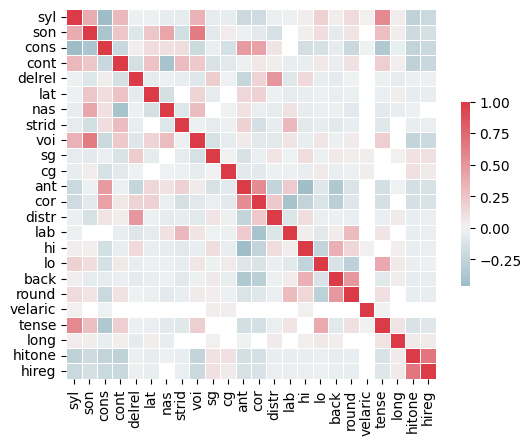

In [481]:
plot(corrs, pvalues)

In [460]:
def plot_heatmap(df):
    corr = df.corr().dropna(axis=1, how="all").dropna(axis=0, how="all")
    f, ax = plt.subplots(figsize=(20,15))
    
    mask = np.triu(np.ones_like(corr, dtype=bool))
    cmap = sns.diverging_palette(230,20, as_cmap=True)
    sns.heatmap(corr, annot=True, mask = mask, cmap=cmap)

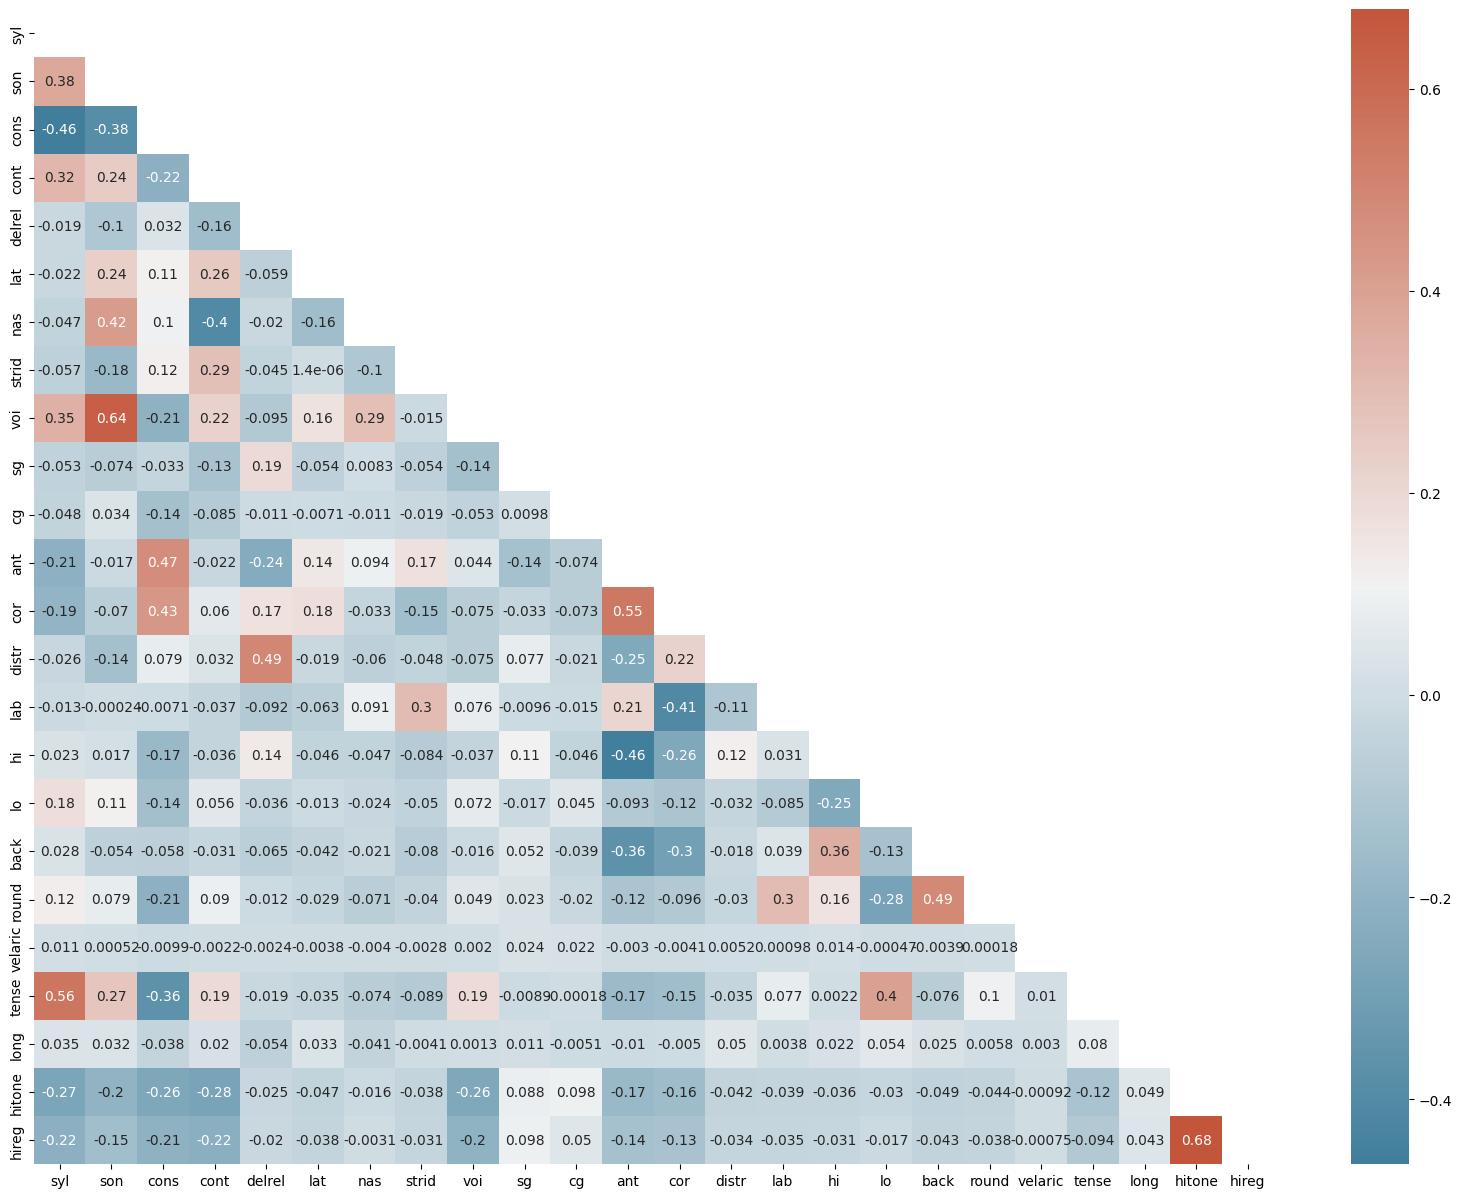

In [461]:
plot_heatmap(df_features)

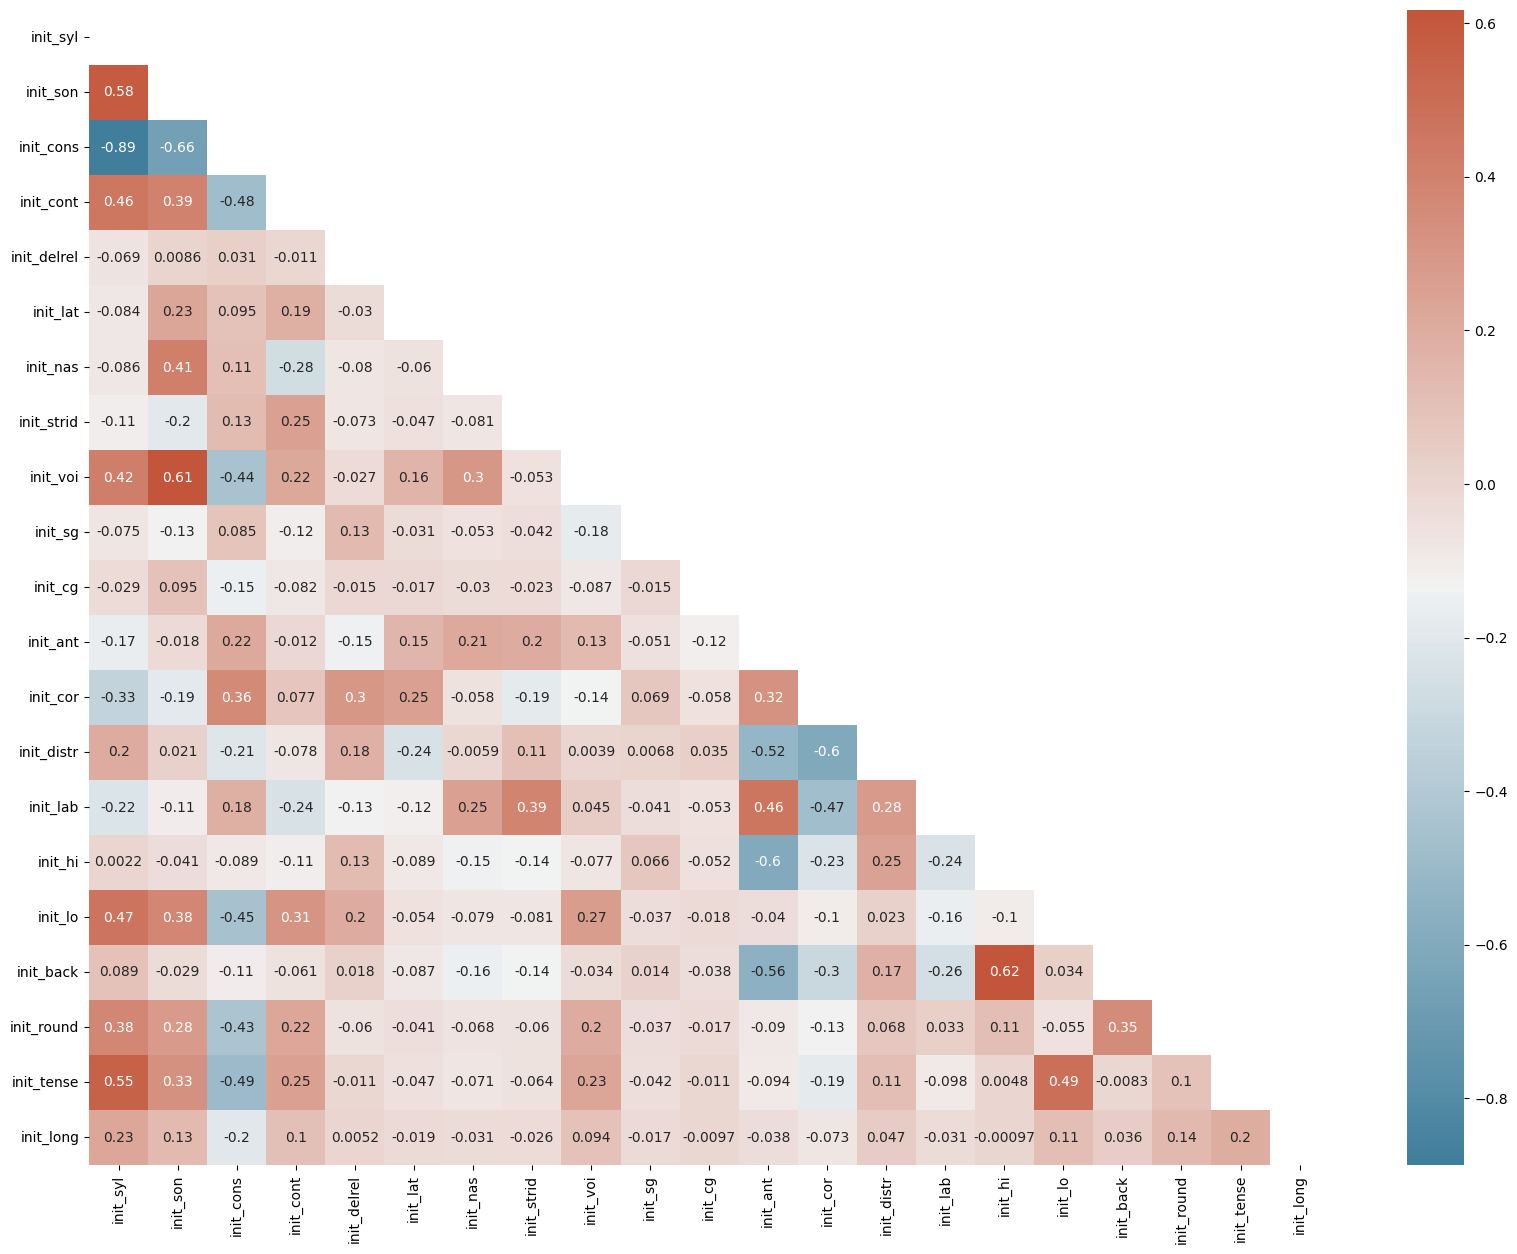

In [462]:
plot_heatmap(df_init_features) # (syl, son, cons, cont) significantly correlate with conc.

In [434]:
def pearsonr(df, feature):
    df_feature= df[["Conc", feature]]
        
    X = df_feature["Conc"].values
    print(X.shape)
    Y = df_feature[feature].values
    print(Y.shape)
    pr = scipy.stats.pearsonr(X,Y)
    return pr.statistic, pr.pvalue
    

In [440]:
pearsonr(phondf, "init_lo")

(77996,)
(77996,)


(-0.0557696457719335, 8.909194715791896e-55)

In [441]:
pearsonr(phondf, "init_hi")

(77996,)
(77996,)


(0.018298832599730107, 3.207961811057286e-07)

In [442]:
pearsonr(phondf, "lo")

(77996,)
(77996,)


(0.04898738849225241, 1.1799151356690582e-42)

In [443]:
pearsonr(phondf, "hi")

(77996,)
(77996,)


(0.01152760019083037, 0.0012843391915099618)

In [433]:
df_voi= phondf[["Conc", "voi"]]
df_voi        

,Conc,voi
0,2.035000,1.000000
1,3.561429,1.000000
2,3.150000,1.000000
3,4.393333,1.000000
4,4.585000,1.000000
...,...,...
77991,3.765000,0.833333
77992,4.880000,0.600000
77993,2.005000,0.666667
77994,2.775000,0.600000


In [432]:
X_df

""


(77996,)
(77996,)


(-0.051191338619547125, 2.0146427476183166e-46)

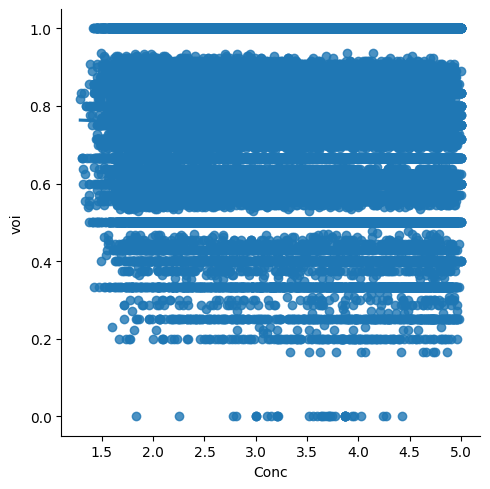

In [425]:
pearsonr(phondf, "voi")

In [412]:
def pearsonr(df, feature, feature_value, concreteness="abstract"):
    df_feature= df[["Conc", feature]]
    if feature_value ==0:
        df_feature_specific = df_feature[df_feature[feature]==feature_value]
    else:
        
        df_feature_specific = df_feature[df_feature[feature]>=feature_value]
        
    print(f"feature {feature}- {feature_value}, {len(df_feature)}")
    
    if concreteness=="abstract":
        df_feature_specific=df_feature_specific[df_feature_specific["Conc"]<3]
    else:
        df_feature_specific=df_feature_specific[df_feature_specific["Conc"]>=3]
    
    X_df = pd.DataFrame.from_dict(df_feature_specific.groupby("Conc").agg("count")[feature].to_dict(), orient="index").rename(columns={0:f"#{feature}"})
    
    X = X_df.index.values
    print(X.shape)
    Y = X_df[f"#{feature}"].values
    print(Y.shape)
    pr = scipy.stats.pearsonr(X,Y)
    return pr.statistic, pr.pvalue
    

In [414]:
pearsonr(phondf, "init_tense", 0.1)

feature init_tense- 0.1, 77996
(1402,)
(1402,)


(0.006605659751503098, 0.8048155725777845)

In [415]:
pearsonr(phondf, "init_round", 0.1,  "abstract")

feature init_round- 0.1, 77996
(711,)
(711,)


(0.07297264127794592, 0.05178039450426392)

In [416]:
pearsonr(phondf, "init_voi", 0.1, "concrete")

feature init_voi- 0.1, 77996
(3017,)
(3017,)


(0.12496352000032883, 5.655437436481965e-12)

In [417]:
pearsonr(phondf, "round", 0.00001, "concrete")

feature round- 1e-05, 77996
(2987,)
(2987,)


(0.1452910712033459, 1.4667685989160657e-15)

In [418]:
pearsonr(phondf, "round", 0, "concrete")

feature round- 0, 77996
(2955,)
(2955,)


(0.16153571540209802, 9.97085678330205e-19)

In [419]:
pearsonr(phondf, "init_tense", 1)

feature init_tense- 1, 77996
(1402,)
(1402,)


(0.006605659751503098, 0.8048155725777845)

In [336]:
pearsonr(phondf, "round", 1, "concrete")

feature round- 1, 129677
(5139,)
(5139,)


(0.13917388579835122, 1.2038911898245155e-23)

In [316]:
def get_feature_df(df, feature, feature_value):
    df_feature= df[["Conc", feature]]
    if feature_value <1:
        df_feature_specific = df_feature[df_feature[feature]<=feature_value]
    else:
        
        df_feature_specific = df_feature[df_feature[feature]>=feature_value]
    print(df_feature_specific)
    sns.histplot(data=df_feature_specific, x="Conc")

         Conc  voi
0       2.470    1
1       2.925    1
2       2.195    2
3       2.355    1
4       2.300    1
...       ...  ...
129672  3.480    2
129673  2.775    3
129674  2.315    8
129675  2.065    5
129676  2.605    5

[129626 rows x 2 columns]


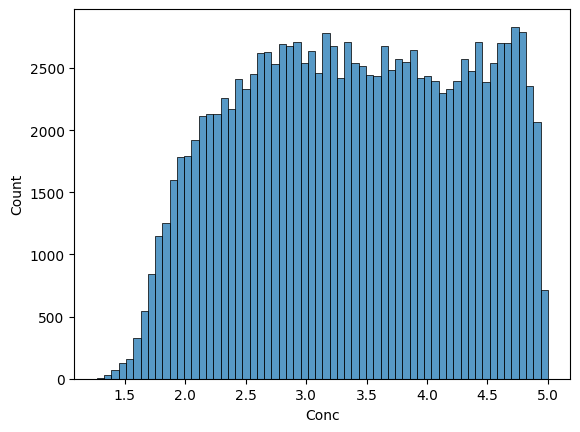

In [317]:
get_feature_df(phondf, "voi", 1) # very few velaric.

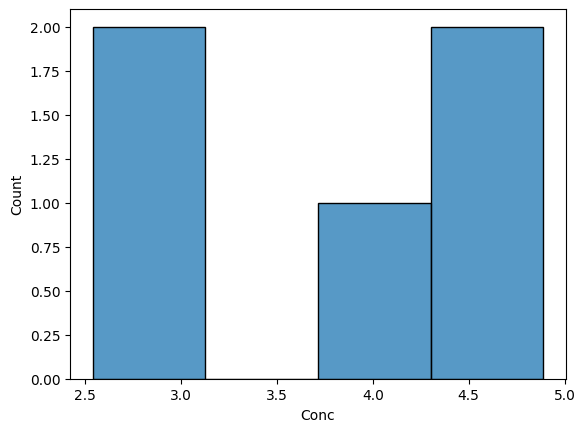

In [310]:
get_feature_df(phondf, "velaric", 1) # very few velaric.

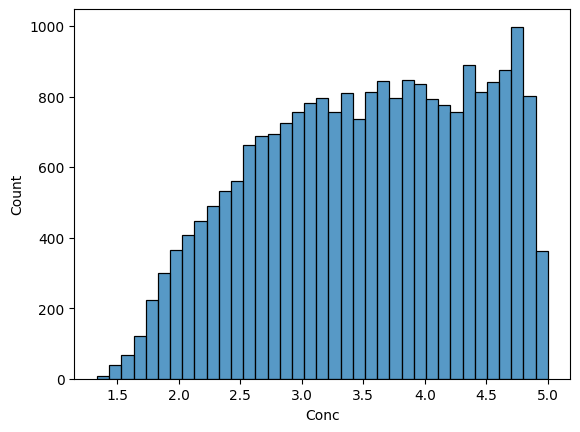

In [308]:
get_feature_df(phondf, "hi", 0) # very few non-voi.

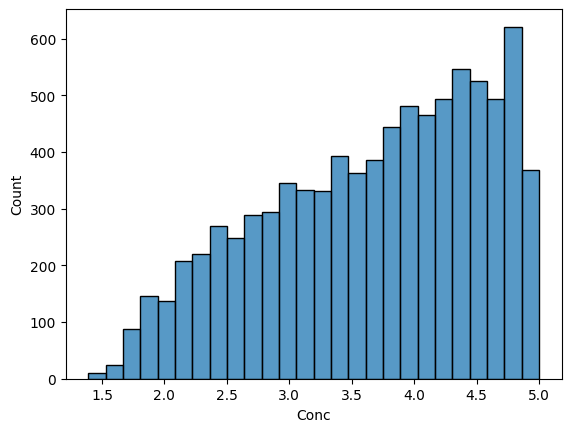

In [300]:
get_feature_df(phondf, "cor", 0) # very few non-voi.

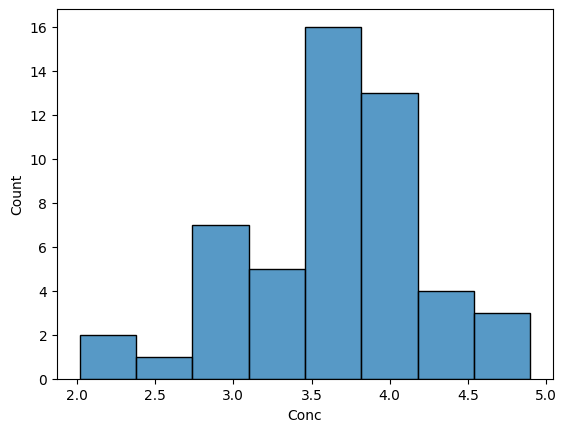

In [292]:
get_feature_df(phondf, "voi", 0) # very few non-voi.

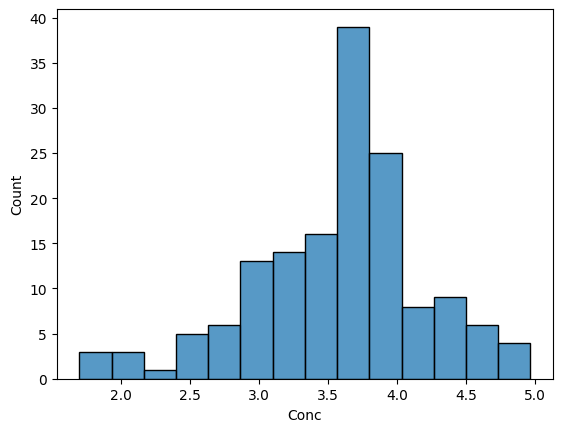

In [279]:
get_feature_df(phondf, "syl", 0) # very few non-syl.

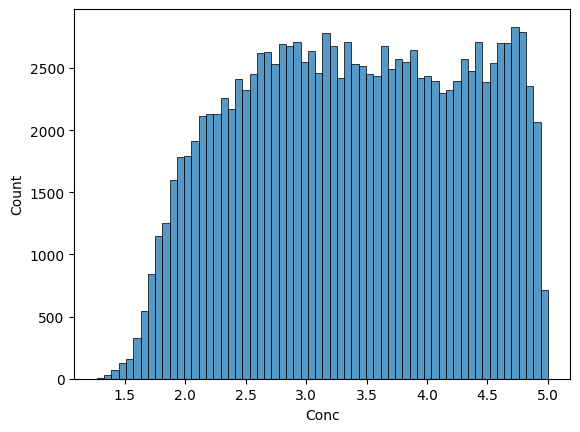

In [276]:
get_feature_df(phondf, "init_hireg", 0) # no initials hireg.

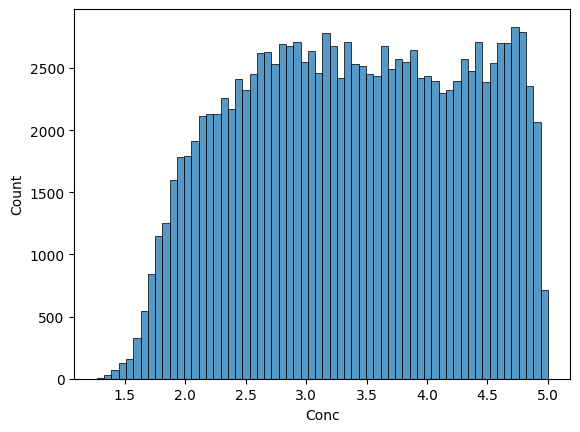

In [273]:
get_feature_df(phondf, "init_hitone",0) # no initials hitone.

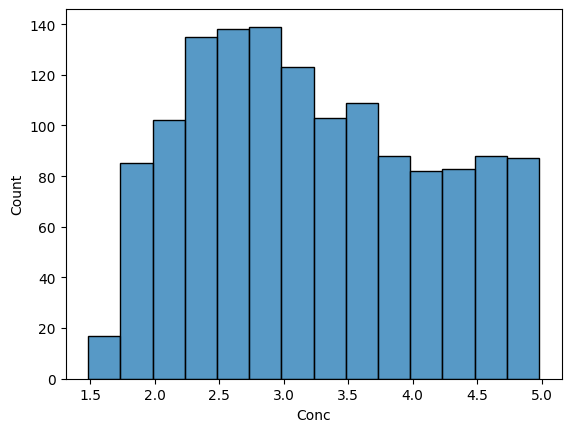

In [269]:
get_feature_df(phondf, "init_long",1)

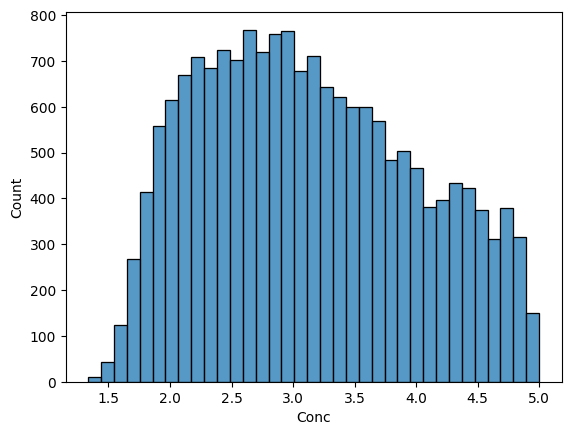

In [266]:
get_feature_df(phondf, "init_tense", 1)

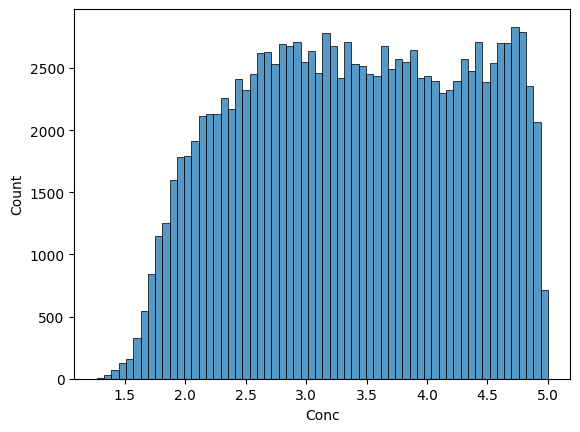

In [262]:
get_feature_df(phondf, "init_velaric", 0)  # no intials are velaric.??????

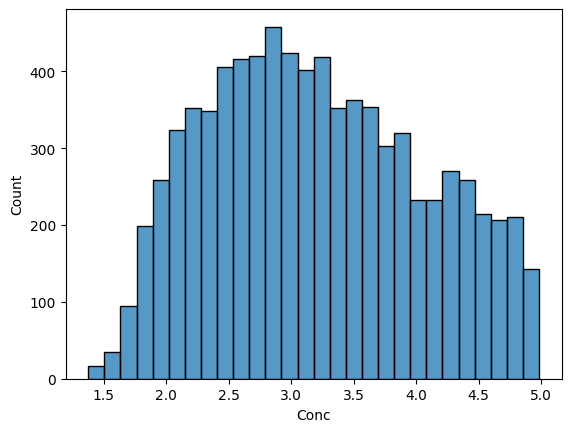

In [252]:
get_feature_df(phondf, "init_lo", 1) 

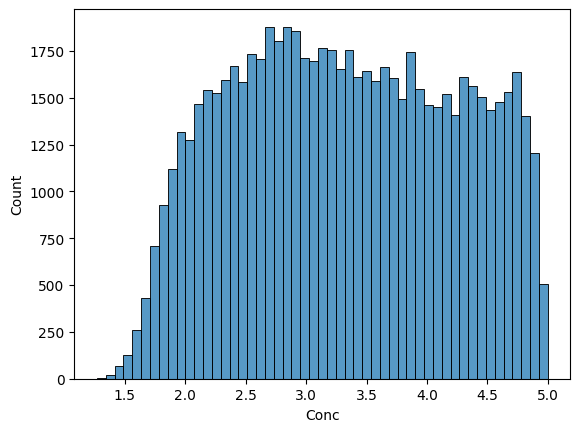

In [240]:
get_feature_df(phondf, "init_voi", 1) 

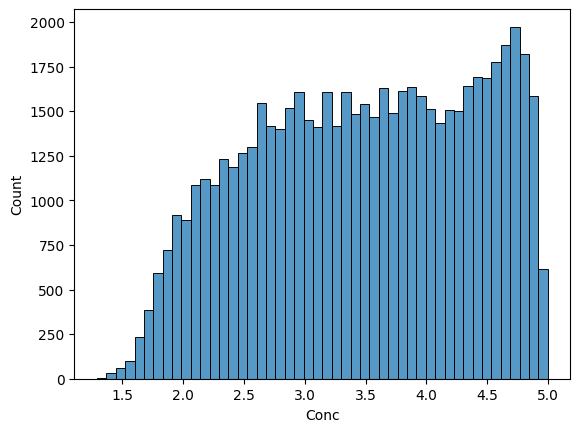

In [239]:
get_feature_df(phondf, "init_voi", 0) 

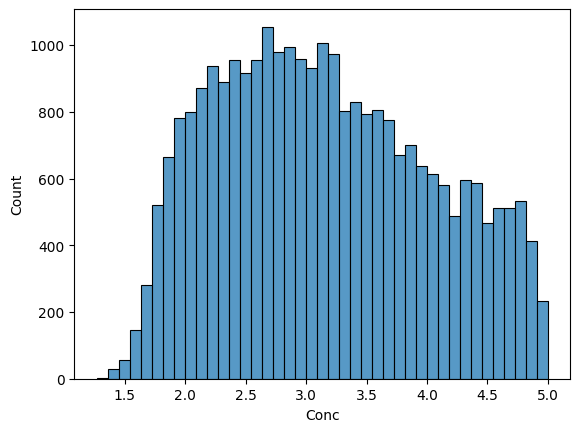

In [222]:
get_feature_df(phondf, "init_cons", 0) # round

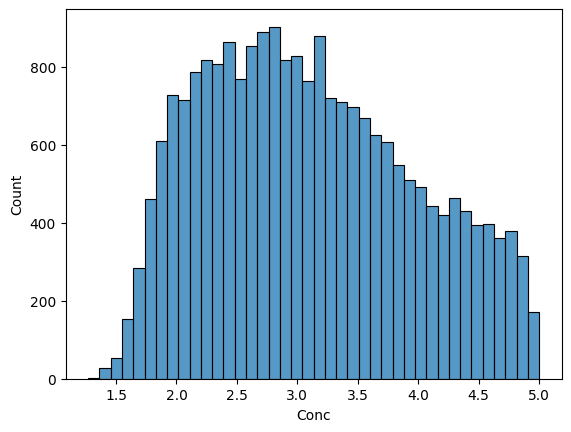

In [217]:
get_feature_df(phondf, "init_syl", 1) # round # more concrete, more vowels initials

In [ ]:
get_feature_df

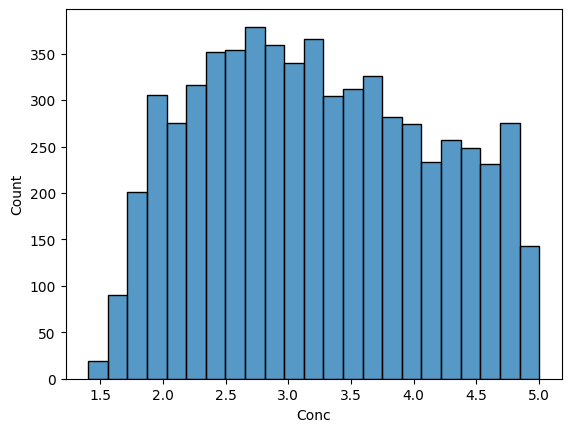

In [204]:
get_feature_df(phondf, "init_round", 1) # round

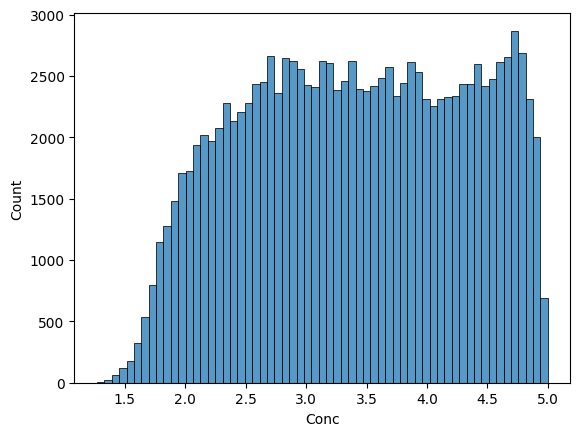

In [206]:
get_feature_df(phondf, "init_round", 0) # round

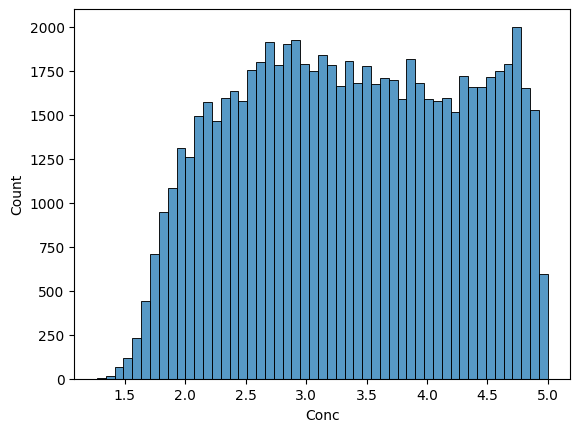

In [202]:
get_feature_df(phondf, "round", 1) # round

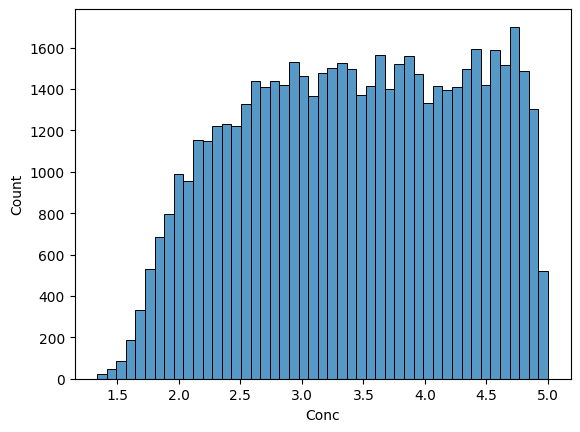

In [203]:
get_feature_df(phondf, "round", 0) # not rounded

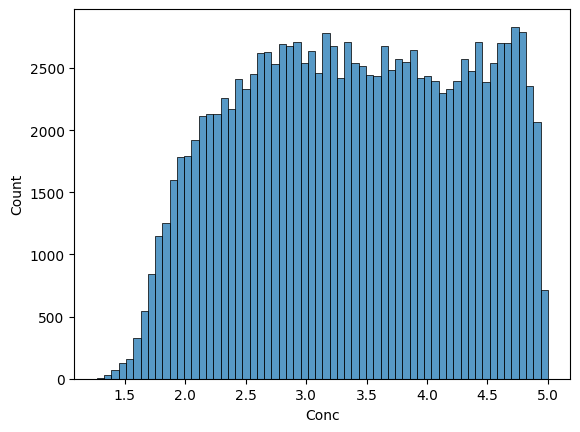

In [200]:
get_feature_df(phondf, "voi", 1) # voice

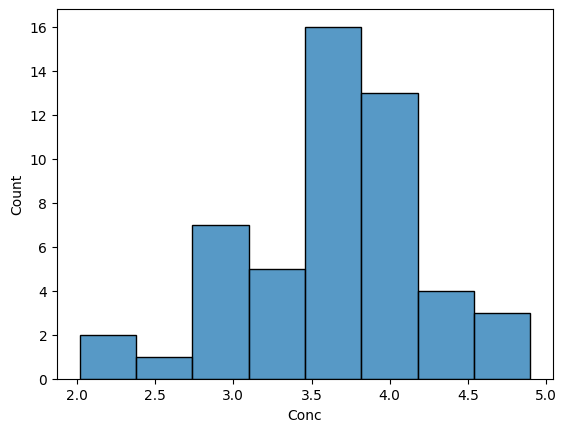

In [201]:
get_feature_df(phondf, "voi", 0) # voiceless

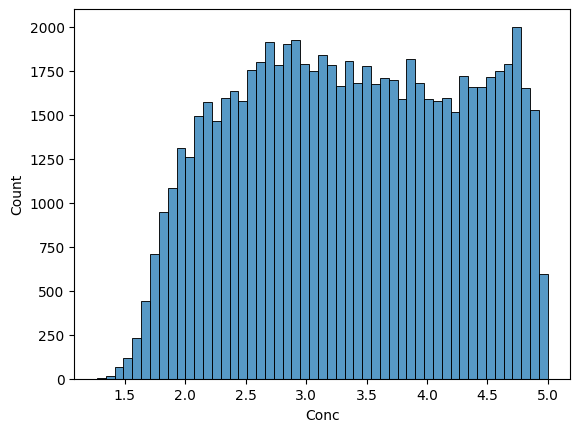

In [199]:
get_feature_df(phondf, "round", 1)

<Axes: xlabel='Conc', ylabel='Count'>

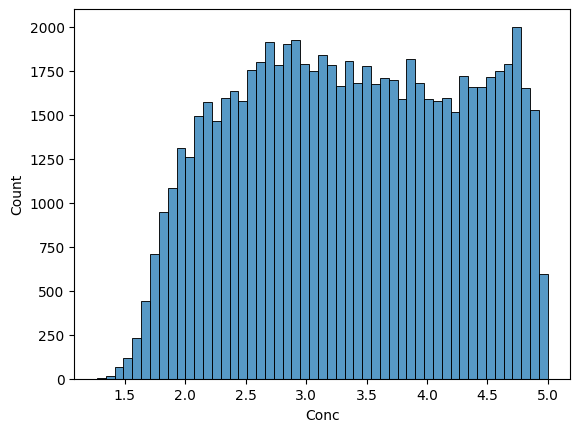

In [189]:
sns.histplot(data=df_round, x="Conc")

In [163]:
df_init_round = get_feature_df(phondf, "init_round", 1)

<Axes: xlabel='Conc', ylabel='Count'>

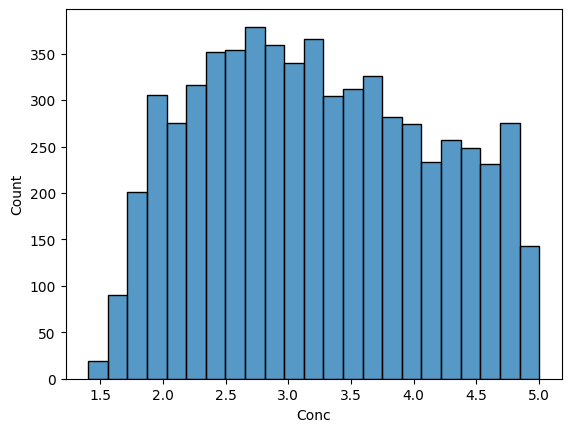

In [164]:
sns.histplot(data=df_init_round, x="Conc")

In [165]:
df_init_not_round = get_feature_df(phondf, "init_round", -1)

<Axes: xlabel='Conc', ylabel='Count'>

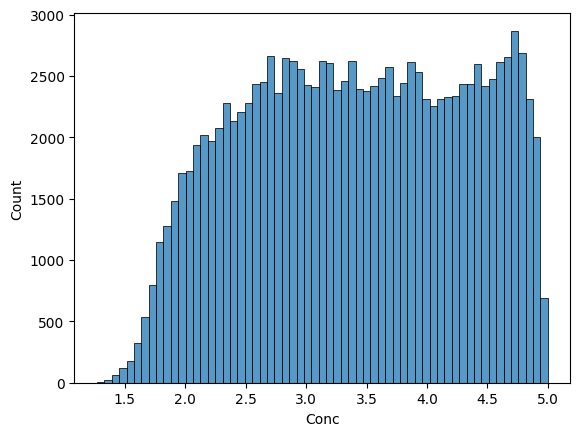

In [166]:
sns.histplot(data=df_init_not_round, x="Conc")

In [156]:
df_init_voi = phondf[["Conc", "init_voi"]]

In [159]:
df_init_voiceless = df_init_voi[df_init_voi["init_voi"]==-1]

<Axes: xlabel='Conc', ylabel='Count'>

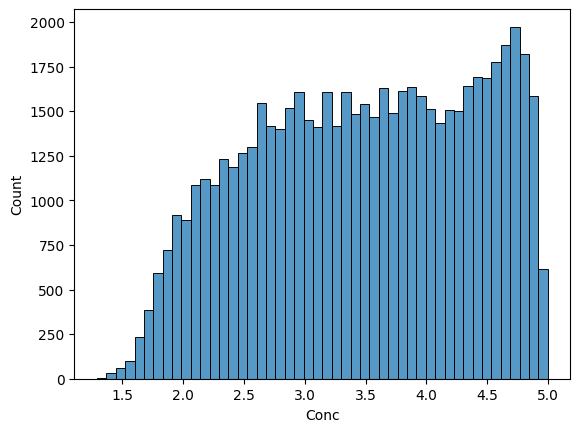

In [160]:
sns.histplot(data=df_init_voiceless, x="Conc")

<Axes: xlabel='Conc', ylabel='Count'>

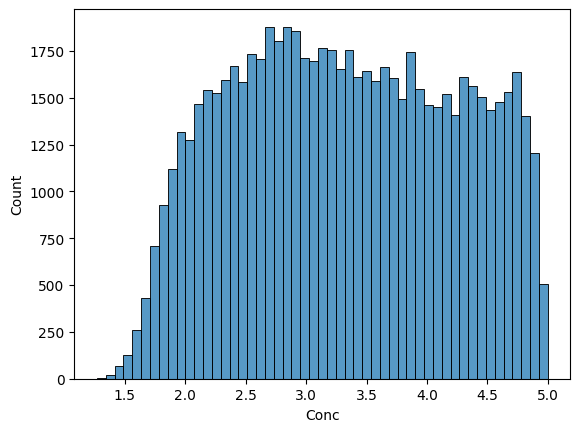

In [161]:
df_init_voice = df_init_voi[df_init_voi["init_voi"]==1]
sns.histplot(data=df_init_voice, x="Conc")

<Axes: xlabel='Conc', ylabel='init_voi'>

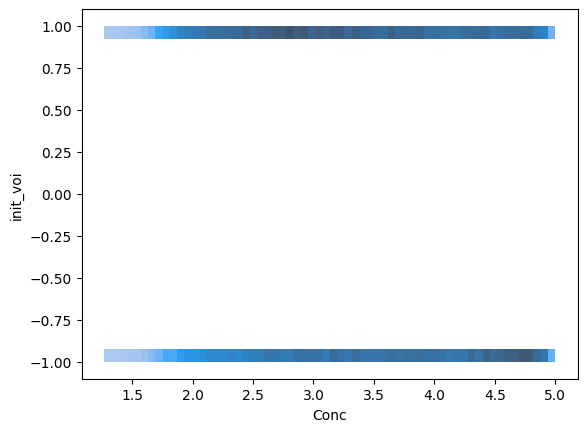

In [148]:
sns.histplot(data=phondf, x="Conc", y="init_voi")

In [42]:
df_p1["P1"].value_counts().to_dict()

{'k': 11670,
 'p': 10177,
 's': 9818,
 'm': 6813,
 't': 5816,
 'b': 5783,
 'a': 5204,
 'd': 5011,
 'f': 4312,
 'l': 3613,
 'r': 3214,
 'v': 3179,
 'n': 2873,
 'ɡ': 2628,
 'i': 2617,
 'h': 2289,
 'e': 2168,
 'ʃ': 1674,
 'z': 1623,
 'j': 1331,
 'o': 1223,
 'ʋ': 1195,
 'ɛ': 1134,
 'ɔ': 1092,
 't͡ɕ': 998,
 'ʁ': 990,
 'ɑ': 975,
 'ɪ': 974,
 'kʰ': 956,
 'ʔ': 929,
 'u': 901,
 't͡ʃ': 839,
 'x': 835,
 'pʰ': 677,
 'tʰ': 671,
 'ə': 629,
 'w': 619,
 'ɹ': 599,
 'ɐ': 593,
 'd͡ʒ': 587,
 't͡s': 539,
 'ɦ': 506,
 'ʂ': 494,
 'ɕ': 487,
 't͡ɕʰ': 422,
 'ɣ': 384,
 'ʒ': 384,
 'sʰ': 357,
 'c': 327,
 'ʊ': 324,
 'aː': 316,
 'ɛ̃': 293,
 '²': 276,
 'y': 268,
 'eː': 258,
 'ʈ͡ʂ': 250,
 'ɾ': 245,
 'ɲ': 240,
 'æ': 239,
 'ɑ̃': 217,
 'ɟ': 207,
 'ʈ͡ʂʰ': 180,
 'ʐ': 178,
 'pʲ': 175,
 'ʌ': 165,
 'θ': 163,
 'sˠ': 153,
 'mʲ': 152,
 'dʲ': 149,
 'd̪': 148,
 'oː': 148,
 'ɑː': 147,
 'q': 145,
 'bʲ': 145,
 'ĩ': 145,
 'uː': 143,
 'bˠ': 135,
 'ɒ': 130,
 't̪': 130,
 'tʲ': 122,
 't͡sʰ': 112,
 'b̥': 111,
 'sʲ': 110,
 'lʲ': 110,
 'ɨ': 10

<Axes: xlabel='P1', ylabel='Count'>

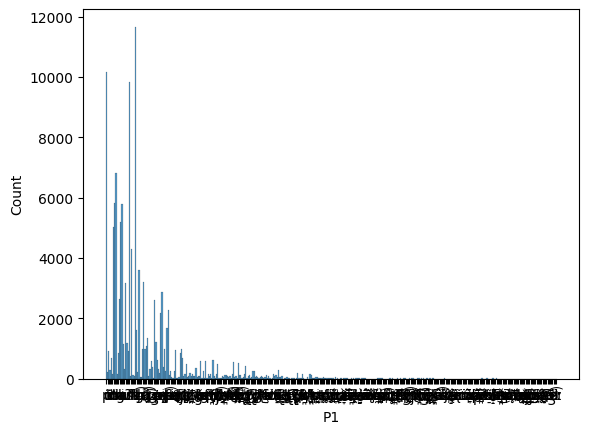

In [37]:
sns.histplot(data= df_p1, x="P1")